In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data
microbes_df = pd.read_csv('Dataset/microbes.csv')
health_df = pd.read_csv('Dataset/gut_health_test.csv')

Detailed Explanation:
- We check for missing values in both datasets to ensure that we have complete data for analysis.
- Missing values can lead to inaccurate results, especially in PCA where the algorithm requires complete data.
- We use the isnull() method to count the number of missing values in each dataset.
- The sum() method is used to get the total number of missing values across all columns.
- If there are missing values, we may need to handle them (e.g., imputation, removal) before proceeding with PCA.

In [4]:
print("Missing values in microbes data:", microbes_df.isnull().sum().sum()) 
print("Missing values in health data:", health_df.isnull().sum().sum())

Missing values in microbes data: 1979
Missing values in health data: 110


Detailed Explanation:
- We check if the subjects in both datasets are aligned, meaning that the same subjects should be present in both datasets.
- This is crucial for merging the datasets correctly.
- We use the unique() method to get the unique subjects from both datasets.
- If there are discrepancies, we may need to filter or align the datasets based on the subjects.
- This ensures that the PCA is performed on the same subjects across both datasets.
- If there are any discrepancies, we can print them out for further investigation.

In [5]:
print("Subjects in microbes data:", microbes_df['subject'].unique())
print("Subjects in health data:", health_df['subject'].unique())

Subjects in microbes data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 26
 27 28 29 30 31 32 33 34 35 36 38 39 41 42 43 44 45 46 47 48 49]
Subjects in health data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 41 42 43 44 45 46 47 48 49]


In [6]:
# Data Cleaning Step 3: Merge datasets
merged_df = pd.merge(health_df, microbes_df, on='subject', how='inner')

In [7]:
# Seperate Features and target variable
X = merged_df.drop(columns=['subject'] + list(health_df.columns[1:]))  # Microbial features
y = merged_df[health_df.columns[1:]]  # Health metrics

In [8]:
print(X.shape, y.shape)  # Check the shape of the dataframes

(45, 1979) (45, 22)


What is PCA? 
- PCA (Principal Component Analysis) is a statistical technique used for dimensionality reduction while preserving as much variance as possible.
- It transforms the original features into a new set of uncorrelated variables called principal components.
- The first principal component captures the most variance, followed by the second, and so on.
- PCA is useful for visualizing high-dimensional data and identifying patterns or clusters.
- It can also help in feature selection by identifying the most important components that explain the variance in the data.
We are using PCA here to reduce the dimensionality of the microbial features while retaining the most important information.
- This will help us visualize the data better and identify any underlying patterns or clusters.

In [11]:
# Dimensionality Reduction with PCA
# First standardize the data
scaler = StandardScaler() # Standardize the features to have mean=0 and variance=1
# This is important for PCA as it is sensitive to the scale of the data.
X_scaled = scaler.fit_transform(X)

In [14]:
# handling NANs
X_scaled = np.nan_to_num(X_scaled)  # Replace NaNs with 0

In [15]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled) 

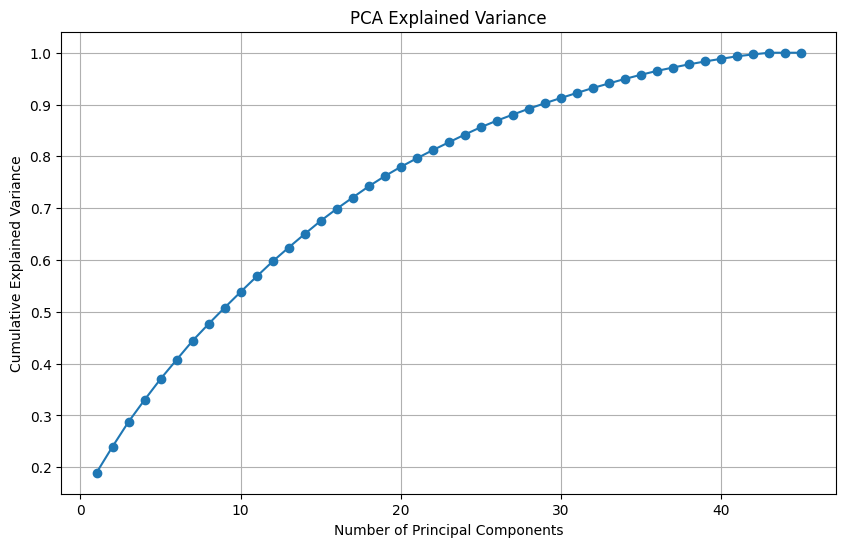

In [16]:
# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


In [17]:
# Let's keep components that explain 95% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

Number of components explaining 95% variance: 35


In [18]:
# Retain only significant components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

In [20]:
print(X_pca.shape)

(45, 35)


In [21]:
# Create a DataFrame with PCA results and health metrics
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
final_df = pd.concat([merged_df['subject'], pca_df, y], axis=1)

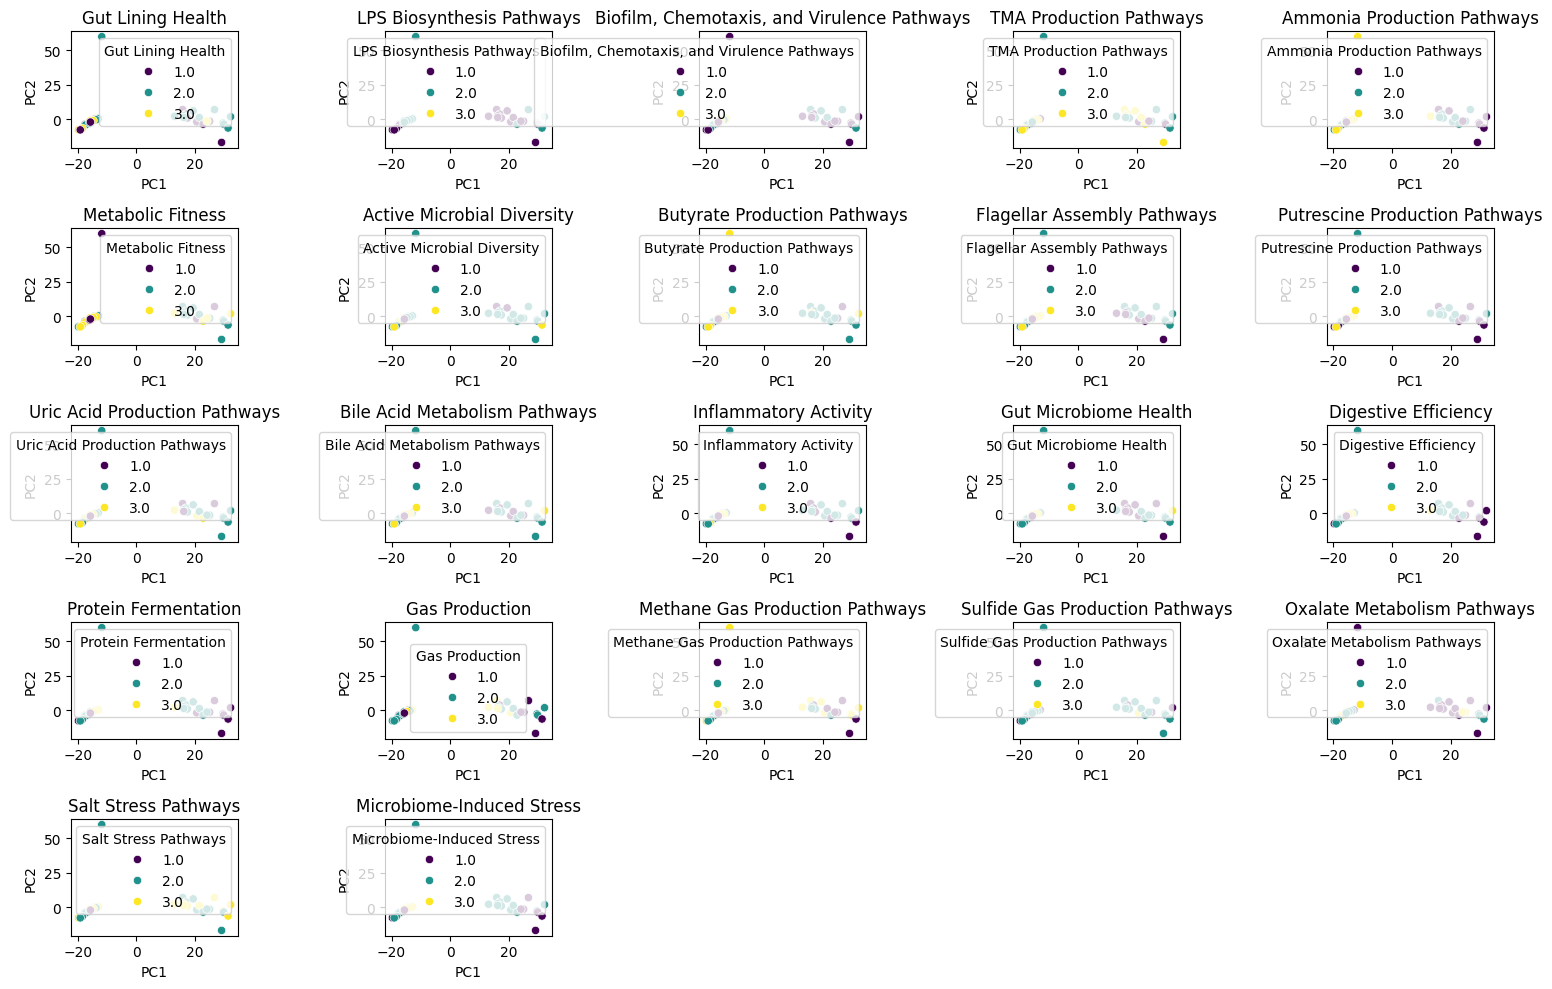

In [41]:
# Visualize PCA components vs health metrics
plt.figure(figsize=(15, 10))
for i, col in enumerate(y.columns):
    plt.subplot(5, 5, i+1)
    sns.scatterplot(data=final_df, x='PC1', y='PC2', hue=col, palette='viridis') 
    plt.title(col)
plt.tight_layout()
plt.show()

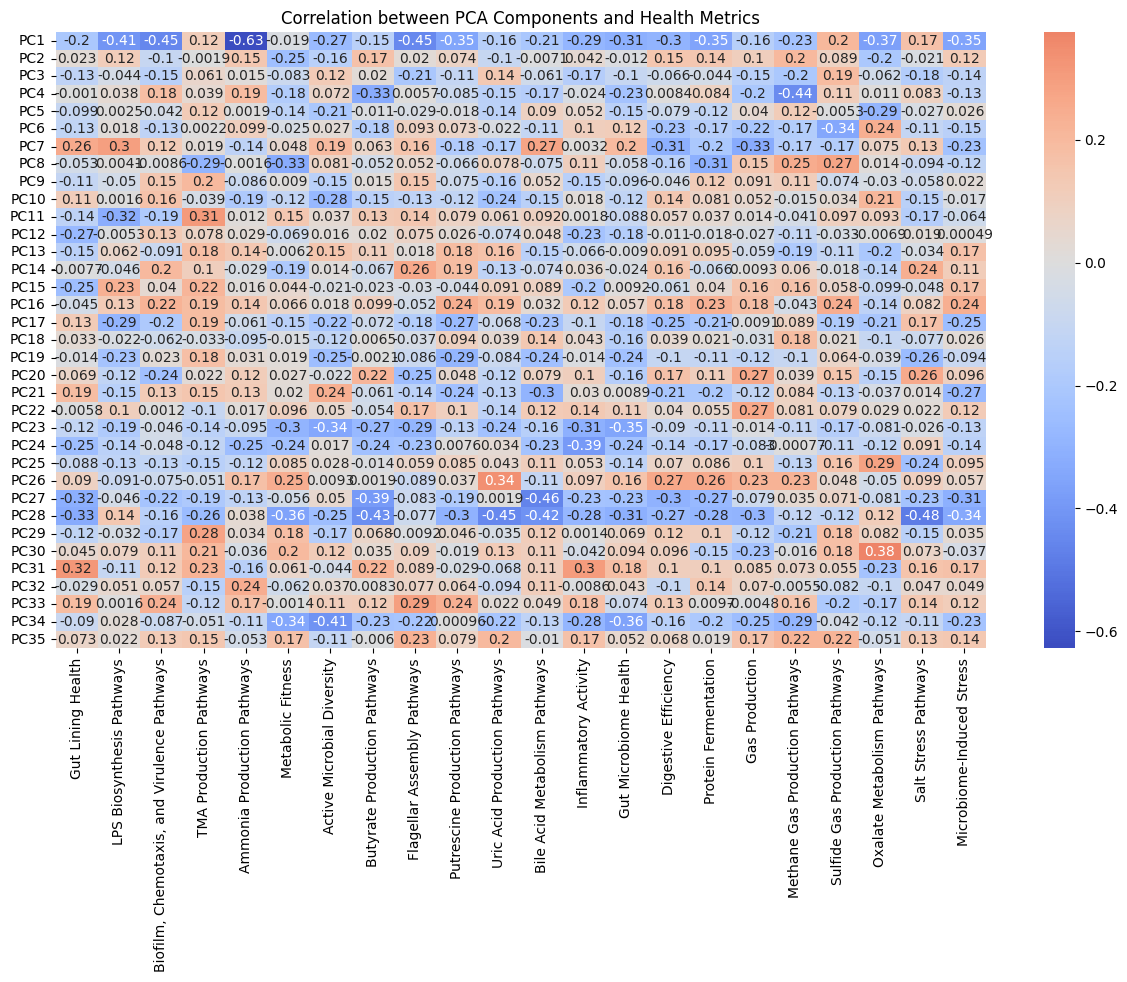

In [43]:
# Correlation analysis between PCA components and health metrics
corr_matrix = pd.concat([pca_df, y], axis=1).corr()
health_corr = corr_matrix.iloc[:n_components, n_components:]
plt.figure(figsize=(15, 8))
sns.heatmap(health_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between PCA Components and Health Metrics')
plt.show()

Detailed Explanation:
- We extract the loadings of the PCA components to identify which microbes contribute most to each principal component.
- The loadings are the coefficients of the linear combination of the original features that form the principal components.
- We create a DataFrame with the loadings for each principal component.
- We then sort the loadings for each component to identify the top contributing microbes.

In [44]:
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)],
                        index=X.columns)

# Get top 10 microbes contributing to each PC
top_microbes = {}
for pc in loadings.columns:
    top_microbes[pc] = loadings[pc].abs().sort_values(ascending=False).head(10).index.tolist()

print("\nTop microbes contributing to each principal component:")
for pc, microbes in top_microbes.items():
    print(f"{pc}: {microbes}")


Top microbes contributing to each principal component:
PC1: ['Blautia wexlerae ', 'Bacteroides sp. HMSC073E02 ', 'Fusicatenibacter saccharivorans ', 'Acinetobacter ', 'Lachnospiraceae bacterium 1_1_57FAA ', 'Lachnospiraceae bacterium 5_1_63FAA ', 'Dorea longicatena strain 2789STDY5834961 ', 'Eubacterium ramulus ATCC 29099 ', 'Oscillibacter sp. ER4 ', 'Oscillospiraceae bacterium VE202-24 ']
PC2: ['Achromobacter ', 'Flavonifractor ', 'Finegoldia ', 'Adlercreutzia ', 'Blautia ', 'Gemella ', 'Schaalia ', 'Selenomonas ', 'Pseudomonas ', 'Treponema ']
PC3: ['Mesorhizobium ', 'Veillonella sp. AS16 ', 'Aggregatibacter sp. oral taxon 458 str. W10330 ', 'Rothia sp. HMSC076D04 ', 'Streptococcus peroris ATCC 700780 ', 'Streptococcus sp. HMSC071D03 ', 'Streptococcus sp. HMSC067H01 ', 'Streptococcus sp. HMSC072D07 ', '[Eubacterium] infirmum ', 'Pseudomonas helleri strain DSM ']
PC4: ['Bifidobacterium mongoliense ', 'Bifidobacterium breve MCC 0121 ', 'Bifidobacterium bifidum strain 85B ', 'Gemella b

In [45]:
# Save cleaned and processed data
final_df.to_csv('cleaned_gut_health_data.csv', index=False)